In [ ]:
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import btk
import btk.catalog
import btk.draw_blends
import btk.sampling_functions
import btk.survey
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from madness_deblender.Deblender import Deblend, compute_residual
from madness_deblender.extraction import extract_cutouts
from madness_deblender.utils import get_data_dir_path, get_madness_deblender_config_path

from madness_benchmark.btksims.sampling import CustomSampling

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
sns.set_theme(
    style={
        "axes.grid": True,
        "axes.labelcolor": "white",
        "figure.facecolor": ".15",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "image.cmap": "viridis",
    }
)

In [ ]:
with open(get_madness_deblender_config_path()) as f:
    madness_deblender_config = yaml.safe_load(f)
btksims_config = madness_deblender_config["btksims"]

# Generate the blended scene

In [ ]:
CATALOG_PATHS = btksims_config["CAT_PATH"][madness_deblender_config["survey_name"]]

stamp_size = 41
min_number = 12
max_number = 20
batch_size = 4
maxshift = 15
num_repetations = 15
survey = btk.survey.get_surveys(madness_deblender_config["survey_name"])
if madness_deblender_config["survey_name"] == "HSC":
    catalog = btk.catalog.CosmosCatalog.from_file(CATALOG_PATHS, exclusion_level="none")
    generator = btk.draw_blends.CosmosGenerator
elif madness_deblender_config["survey_name"] == "LSST":
    catalog = btk.catalog.CatsimCatalog.from_file(CATALOG_PATHS)
    generator = btk.draw_blends.CatsimGenerator
index_range = [200000, len(catalog.table)]
survey = btk.survey.get_surveys(madness_deblender_config["survey_name"])
seed = 13

linear_norm_coeff = 10000

sampling_function = CustomSampling(
    index_range=index_range,
    min_number=min_number,
    max_number=max_number,
    maxshift=maxshift,
    stamp_size=stamp_size,
    seed=seed,
    unique=False,
)


draw_generator = generator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    verbose=False,
    seed=seed,
)

In [ ]:
catalog.table.columns

<TableColumns names=('galtileid','ra','dec','redshift','fluxnorm_bulge','fluxnorm_disk','fluxnorm_agn','a_b','a_d','b_b','b_d','pa_bulge','pa_disk','u_ab','g_ab','r_ab','i_ab','z_ab','y_ab','r_band_snr')>

In [ ]:
blend = next(draw_generator)

blend.catalog_list[0]["x_peak"]

np.shape(blend.blend_images[0])

(6, 205, 205)

In [ ]:
import pickle

save_file_name = os.path.join(get_data_dir_path(), "example_blend.pkl")
with open(save_file_name, "wb") as pickle_file:
    pickle.dump(blend, pickle_file)

### choose the field to deblend

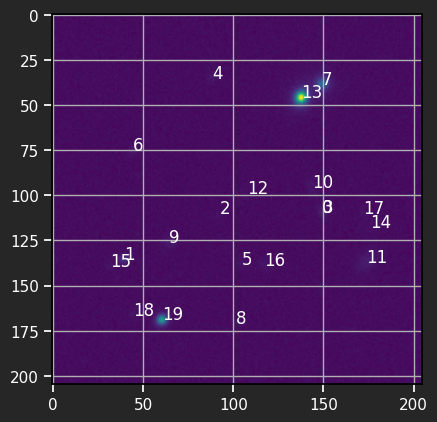

In [ ]:
# print("input_image")
band_num = 2
field_example_to_display = 0
plt.imshow(blend.blend_images[field_example_to_display, band_num])
for i in range(len(blend.catalog_list[field_example_to_display])):
    plt.text(
        blend.catalog_list[field_example_to_display]["x_peak"][i],
        blend.catalog_list[field_example_to_display]["y_peak"][i],
        str(i),
    )

input_image


<Figure size 1000x1000 with 0 Axes>

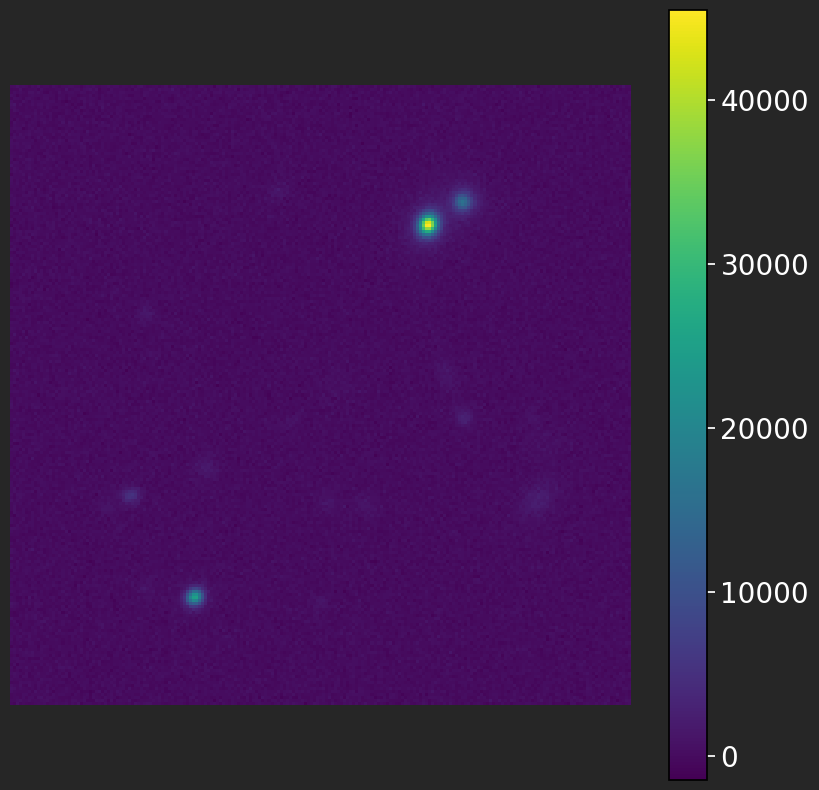

In [ ]:
fig = plt.figure(figsize=(10, 10))
print("input_image")
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
im1 = ax.imshow(blend.blend_images[field_example_to_display, 2])
# for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i],
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
# plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")

# Initialize the Deblender

In [ ]:
tf.get_logger().setLevel("ERROR")

latent_dim = 16
kl_weight = 1

weights_path = os.path.join(
    get_data_dir_path(), madness_deblender_config["survey_name"] + "0.01"
)
deb = Deblend(latent_dim=16, weights_path=weights_path, survey=survey)

field = blend.blend_images

In [ ]:
deb.flow_vae_net.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45, 45, 6)]       0         
                                                                 
 conv2d (Conv2D)             (None, 23, 23, 32)        4832      
                                                                 
 p_re_lu (PReLU)             (None, 23, 23, 32)        16928     
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       102528    
                                                                 
 p_re_lu_1 (PReLU)           (None, 12, 12, 128)       18432     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 256)         819456    
                                                                 
 p_re_lu_2 (PReLU)           (None, 6, 6, 256)         9216

# Run MADNESS

In [ ]:
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    rtol=0.05,
    min_num_steps=40,
    window_size=15,
)

initial_lr = 0.025
if madness_deblender_config["survey_name"] == "LSST":
    initial_lr = 0.05

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=30,
    decay_rate=0.8,
    staircase=True,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
# optimizer=tfa.optimizers.AdaBelief(learning_rate=lr_scheduler)

detected_positions = np.zeros((len(blend.catalog_list), max_number, 2))
num_components = []
for field_num in range(len(blend.catalog_list)):
    for gal_num in range(len(blend.catalog_list[field_num])):
        detected_positions[field_num][gal_num][0] = blend.catalog_list[field_num][
            "y_peak"
        ][gal_num]
        detected_positions[field_num][gal_num][1] = blend.catalog_list[field_num][
            "x_peak"
        ][gal_num]
    num_components.append(len(blend.catalog_list[field_num]))

deb(
    blended_fields=blend.blend_images,
    detected_positions=detected_positions,
    num_components=num_components,
    use_log_prob=True,
    linear_norm_coeff=linear_norm_coeff,
    max_iter=200,
    convergence_criterion=convergence_criterion,
    optimizer=optimizer,
    use_debvader=True,
)

use debvader: True

Using encoder for initial point
Time taken for initialization: 0.7330977916717529

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 200
Number of fields: 4
Number of Galaxies: [20 14 12 16]
Dimensions of latent space: 16
--- Gradient descent complete ---
Time taken for gradient descent: 115.40070581436157


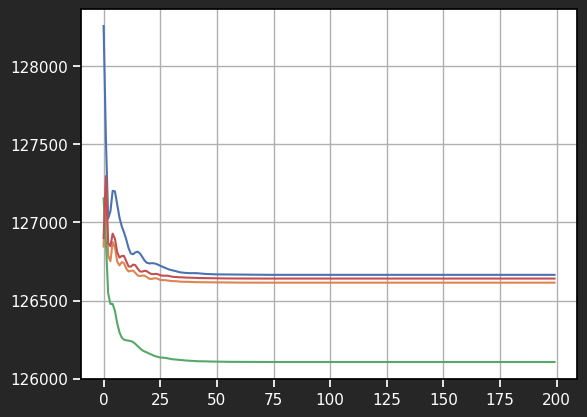

In [ ]:
plt.plot(deb.results);

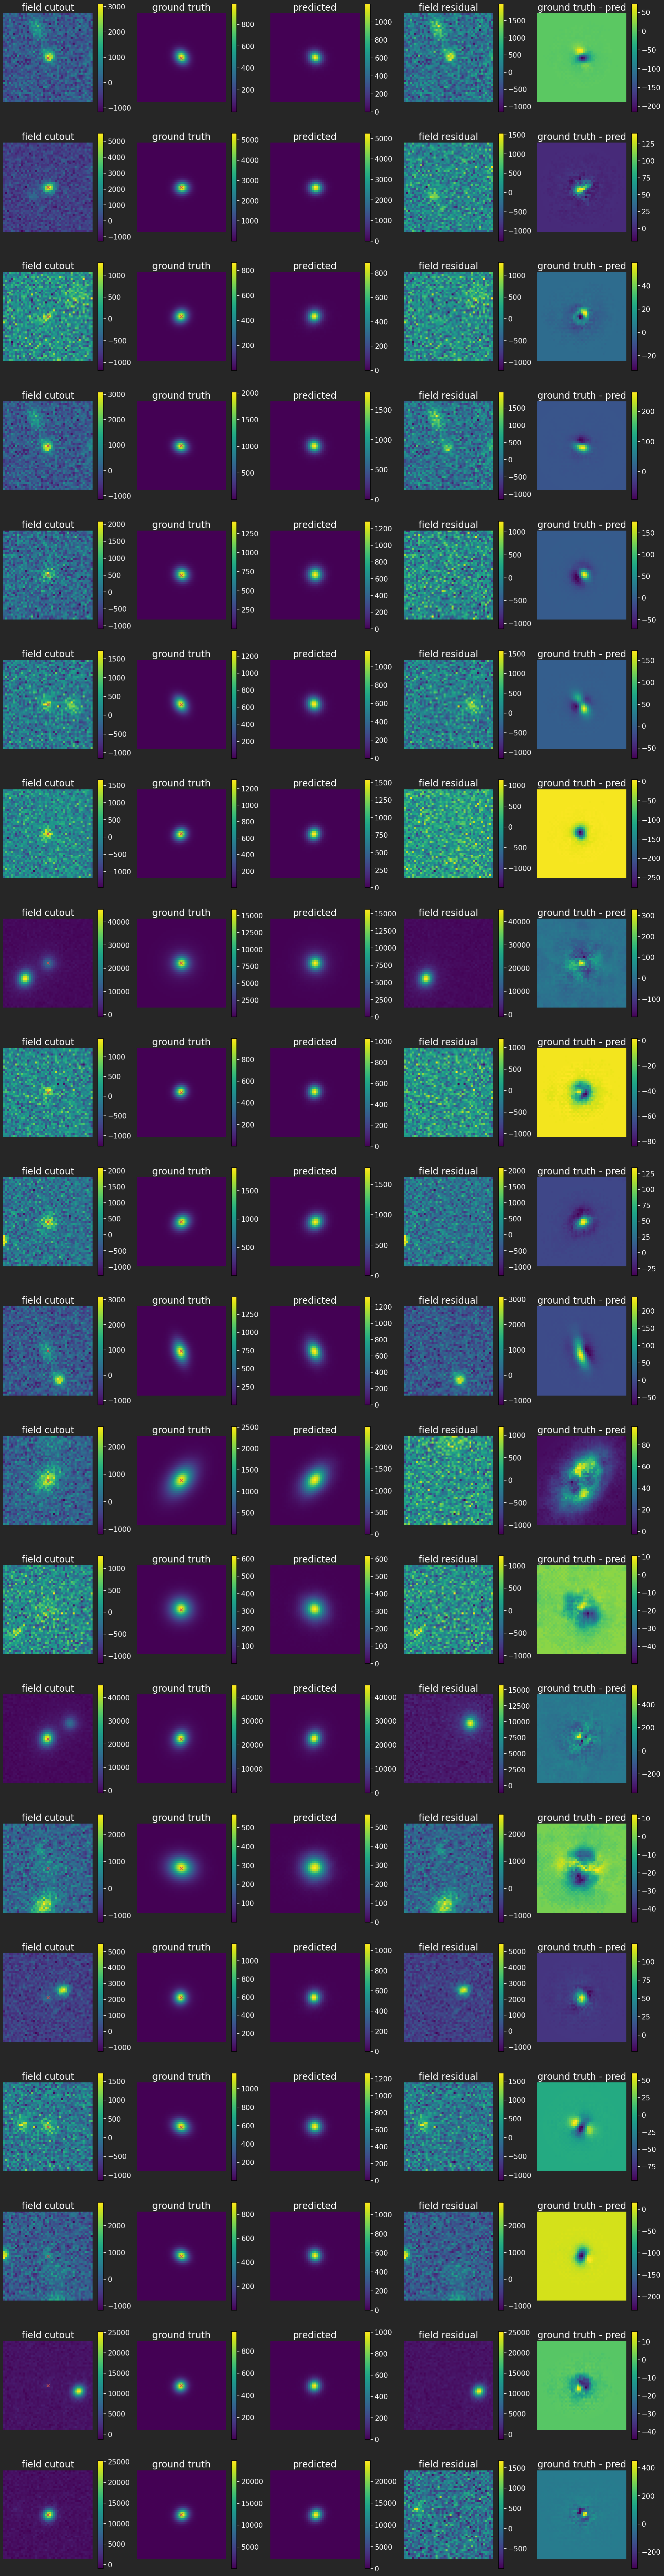

In [ ]:
fig, ax = plt.subplots(
    len(blend.catalog_list[field_example_to_display]),
    5,
    figsize=(5 * 5, 5 * len(blend.catalog_list[0])),
)

for i in range(len(blend.catalog_list[field_example_to_display])):

    # print("image number: " + str(i))
    # image_index = shuffled_indices[i]
    field_cutout_r_band = extract_cutouts(
        blend.blend_images[field_example_to_display],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        channel_last=False,
        cutout_size=45,
    )[0][0, :, :, 2]
    galaxy_cutout_r_band = extract_cutouts(
        blend.isolated_images[field_example_to_display][i],
        [detected_positions[field_example_to_display][i]],
        distances_to_center=False,
        cutout_size=45,
    )[0][0, :, :, 2]

    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis("off")

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis("off")

    im2 = ax[i, 2].imshow(deb.components[field_example_to_display][i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis("off")

    im3 = ax[i, 3].imshow(
        field_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis("off")

    im3 = ax[i, 4].imshow(
        galaxy_cutout_r_band - deb.components[field_example_to_display][i][:, :, 2]
    )
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis("off")

plt.savefig("MAP_predictions")
plt.show()

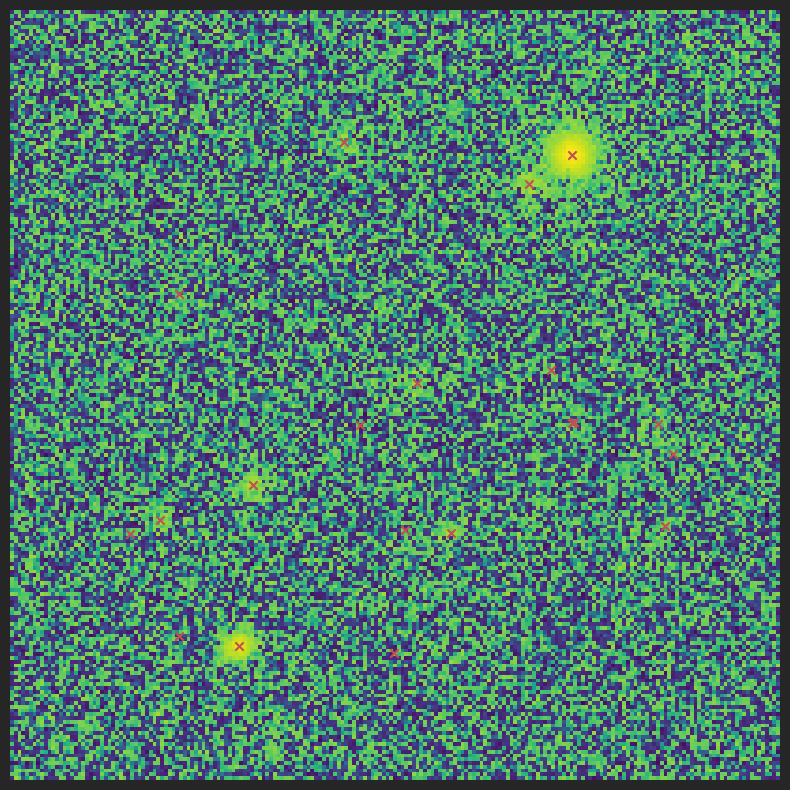

In [ ]:
# This is just to make the blends more visible

sns.set_theme(
    style={
        "axes.grid": False,
        "axes.labelcolor": "white",
        "figure.facecolor": ".15",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "image.cmap": "viridis",
    }
)

fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.arcsinh(blend.blend_images[field_example_to_display][0]))
for i in range(len(blend.catalog_list[field_example_to_display])):
    plt.scatter(
        blend.catalog_list[field_example_to_display]["x_peak"][i],
        blend.catalog_list[field_example_to_display]["y_peak"][i],
        marker="x",
        c="r",
    )

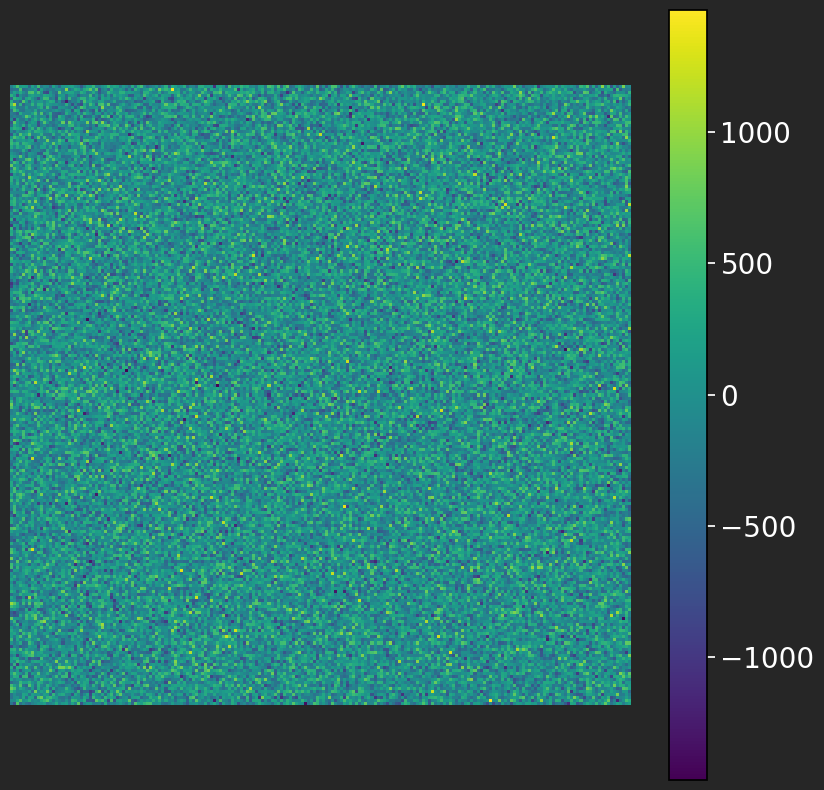

In [ ]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
index_pos_to_sub = deb.get_index_pos_to_sub()
residual = compute_residual(
    blended_field=np.transpose(
        blend.blend_images[field_example_to_display], axes=[1, 2, 0]
    ),
    reconstructions=deb.components[field_example_to_display],
    index_pos_to_sub=index_pos_to_sub[field_example_to_display],
    num_components=num_components[field_example_to_display],
).numpy()
# residual = np.transpose(deb.postage_stamp,
im1 = ax.imshow(residual[:, :, 2])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

# for i in range(len(blend['blend_list'][0])):
# plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

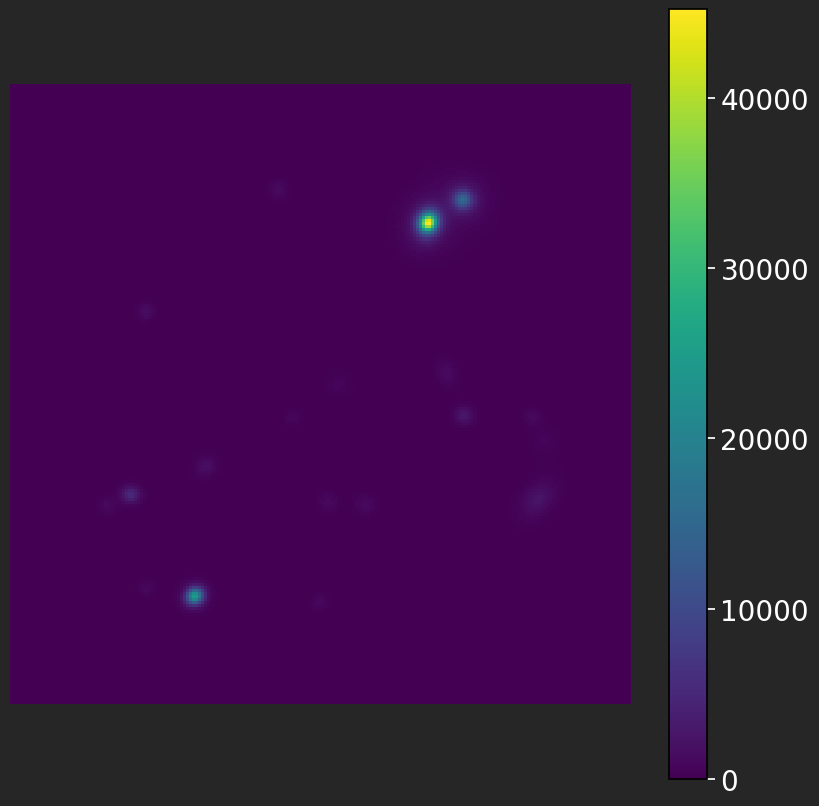

In [ ]:
sns.set_theme(
    style={
        "axes.grid": False,
        "axes.labelcolor": "white",
        "figure.facecolor": ".15",
        "xtick.color": "white",
        "ytick.color": "white",
        "text.color": "white",
        "image.cmap": "viridis",
    }
)
predicted_field = blend.blend_images[field_example_to_display] - np.transpose(
    residual, axes=[2, 0, 1]
)
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[2, :, :])
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();